# To-do's
* Clustering

In [1]:
# Models
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

# Preprocessing
from sklearn.preprocessing import normalize
from keras.preprocessing.image import ImageDataGenerator

# Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# Visualization
from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams['image.cmap']='gray'

# Core
import pandas as pd
import numpy as np

Using TensorFlow backend.


### Add custom database $\rightarrow$ MNIST in CSV

With more data, our model will perform better

In [2]:
col_names = ['label']+[str(x) for x in range(784)]
df = pd.concat([
    pd.read_csv('../input/mnist-in-csv/mnist_train.csv', names=col_names, header=0),  # Extra dataset
    pd.read_csv('../input/mnist-in-csv/mnist_test.csv', names=col_names, header=0),
    pd.read_csv('../input/digit-recognizer/train.csv', names=col_names, header=0),    # Regular dataset
    pd.read_csv('../input/digit-recognizer/test.csv', names=col_names[1:], header=0),
], axis=0, sort=False, ignore_index=True)

In [3]:
num_classes = 10 # Converting y labels from (0, 1, 2, ...) to [1 0 0 0 0 0 0 0 0 0], [0 1 0 0 0 0 0 0 0 0], etc
X, y = df[col_names[1:]], df[col_names[0]]

# Exploration

## Clustering

Unfortunately, clustering and 2D-embedding those data takes too long. So, won't execute it.

In [4]:
#cluster = LocallyLinearEmbedding(n_components=2, n_jobs=-1)
#z = cluster.fit_transform(X.loc[np.isnan(y), :]).T

In [5]:
#clusters = [LocallyLinearEmbedding(n_components=2), SpectralEmbedding(n_components=2)]
#fig, axs = plt.subplots(len(clusters), 1, figsize=(20,30))
#for i, cluster in enumerate(clusters):
#    z = cluster.fit_transform(X.loc[np.isnan(y), :]).T
#    axs[i] = plt.scatter(z[0], z[1], c=ytrain)

Examples of each digit


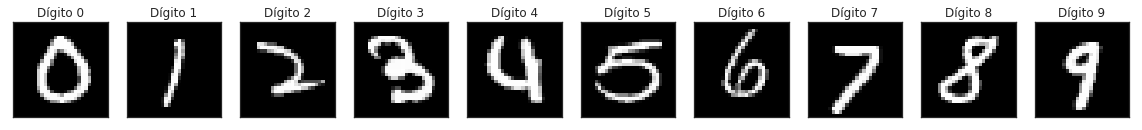

In [6]:
number_n = 10
f, axs = plt.subplots(1, number_n, figsize=(20,3))

print("Examples of each digit")
for n in range(number_n-1, -1, -1):
    ax = axs[n]
    sample = y[y==n].sample(1).index
    ax.imshow(X.loc[sample].values.reshape(28, 28))
    ax.set_title(u"Dígito {:d}".format(int(y[sample])))
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.show();

## Counts Each Digit

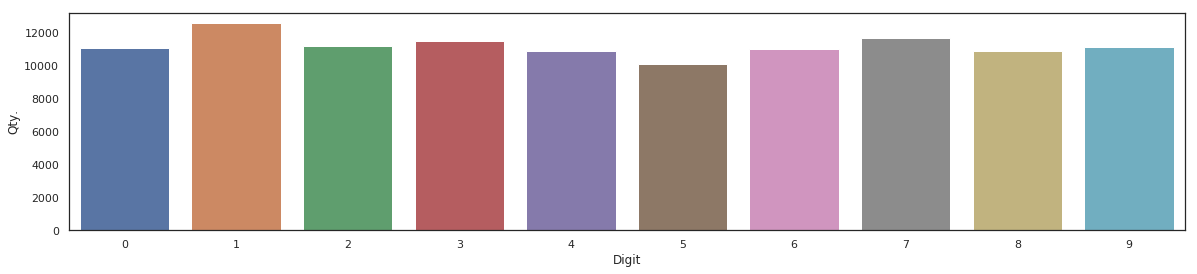

In [7]:
fig, ax = plt.subplots(figsize=(20, 4))
sns.countplot(y[y.notna()].apply(int))
ax.set_ylabel("Qty.")
ax.set_xlabel("Digit")
plt.show();

# Preprocessing

## Normalization

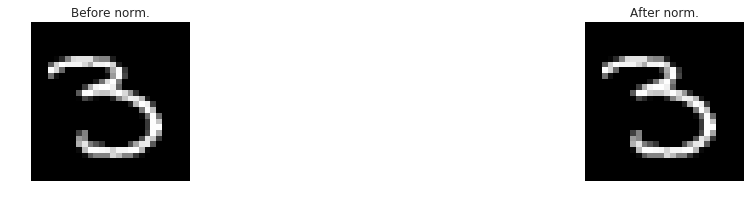

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
sample = y[y.notna()].sample(1).index
ax[0].imshow(X.iloc[sample].values.reshape(28, 28))
ax[0].set_title("Before norm.")
ax[0].axis('off')
X_norm = normalize(X, axis=1, norm='l2');
ax[1].imshow(X_norm[sample].reshape(28, 28))
ax[1].set_title("After norm.")
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [13]:
X = X_norm.reshape(X.shape[0], 28, 28, 1)

# Modeling

In [14]:
train = y.notna()
test = ~train

# convert to binary matrix
y_matrix = (y[:,None] == range(num_classes)).astype(int)

Xtrain, ytrain = X[train], y_matrix[train]
Xtest , ytest  = X[test] , y_matrix[test]

In [15]:
def baseline_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(6, 6), strides=(2, 2), activation='relu',input_shape=Xtrain[0].shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [31]:
estimator = baseline_model()
estimator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 12, 12, 32)        1184      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_5 (Dense)              (None, 25)                2525      
__________

## Augmentation

In [28]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=None,
    shear_range=5,
    zoom_range=-0.4,
    fill_mode='nearest',
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.2
)

In [29]:
datagen.fit(Xtrain)

### View Augmentation

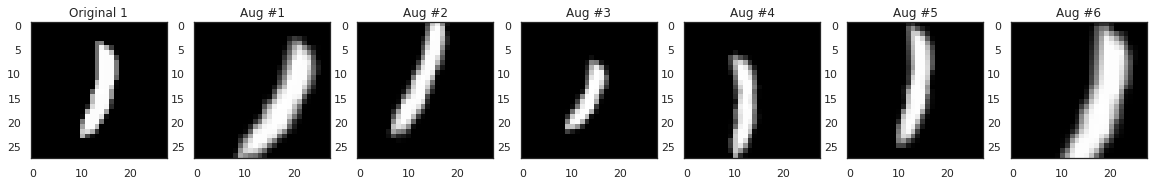

In [30]:
def view_aug(x, y, n=6):
    plt.subplots(1, n+1, figsize=(20,5))
    for i in range(n+1):
        aug = x if i==0 else next(datagen.flow(np.array([x]), np.array([y]), batch_size=4))[0]
        plt.subplot(1, n+1, i+1)
        plt.imshow(aug.reshape(28, 28))
        plt.title("Original %d"%y.argmax() if i==0 else "Aug #%s"%i)
    plt.show()

org_sample = np.random.randint(0, Xtrain.shape[0])
view_aug(Xtrain[org_sample], ytrain[org_sample])

In [ ]:
augmentation = True
if augmentation:
    history = estimator.fit_generator(
        datagen.flow(Xtrain, ytrain, batch_size=10),
        steps_per_epoch=Xtrain.shape[0],
        epochs=10
    )
else:
    history = estimator.fit(
        Xtrain, ytrain,
        batch_size=32, epochs=10,
        validation_split=len(ytest)/len(y)
    )

Epoch 1/10
  8285/112000 [=>............................] - ETA: 10:38 - loss: 0.5142 - acc: 0.8353

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(range(1, len(history.history['loss'])+1), history.history['loss'], label='loss')
plt.scatter(range(1, len(history.history['acc'])+1), history.history['acc'], label='acc')
plt.legend()
plt.show();

In [ ]:
ytest = estimator.predict_classes(Xtest)

In [ ]:
submit = pd.DataFrame(data={'ImageId': range(1, ytest.shape[0]+1), 'Label': ytest})

In [ ]:
submit.to_csv("submit.csv", index=None)